In [1]:
import json
import numpy as np
import requests

import zlib
from io import BytesIO
from urllib import request as urlrequest

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt

%matplotlib inline

classes = ['d10','d12','d20','d4','d6','d8','dicesback']


def uncompress_nparr(bytestring):
    """
    code from https://gist.github.com/andres-fr/f9c0d5993d7e7b36e838744291c26dde
    """
    return np.load(BytesIO(zlib.decompress(bytestring)), allow_pickle=True)


def download_image(url):
    
    with urlrequest.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img.resize((64,64), Image.NEAREST)

with open("test-urls.txt", "rt") as f_in:
    urls=f_in.read()

lst_urls = urls.replace("\n", "").replace('"', '').split(",")

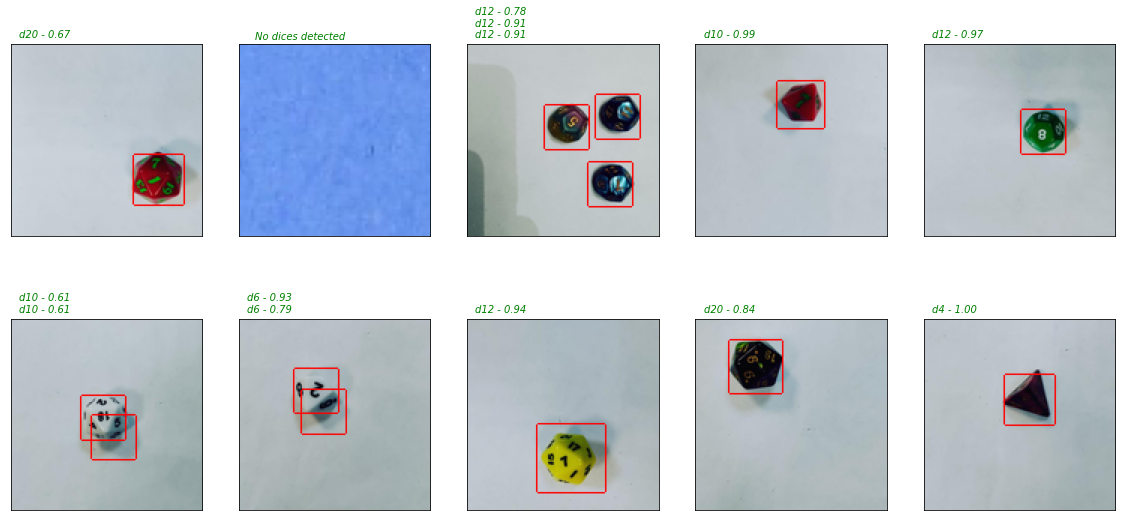

In [4]:
# url = "http://localhost:9696/predict" # uncomment for testing local Flask app
url = "http://localhost:8080/predict" # for testing Kubernetes deployment

N = 10 # number of samples to predict and plot - better to be even

idx = np.random.choice(lst_urls, size=N, replace=False)
random_samples = idx

fig, axes = plt.subplots(2, N//2, figsize=(16, 8))
axes = axes.flatten()


for i, test_url in enumerate(random_samples):
    test = {'url': test_url}

    response = requests.post(url, json=test)
    
    try:
        np_arr = uncompress_nparr(response.content)
        class_labels, result = np_arr[0], np_arr[1]
        
        titles=str()
        for label in class_labels:
            class_prob = sorted(dict(zip(classes, label)).items(), reverse=True, key=lambda x: x[1])[0]
            titles +=f"{class_prob[0]} - {class_prob[1]:.2f}\n"

        if isinstance(result, np.ndarray):
            # axes[i].imshow(((result + 1.)*127.5).astype('int')) # for xception preprocessor
            axes[i].imshow(result) # for standart preprocessor
            axes[i].text(5,3, titles, color='green', fontstyle='italic')
            
    except:
        sample_img_original = download_image(test_url)
        axes[i].imshow(np.array(sample_img_original))
        axes[i].text(5, -2, "No dices detected", color='green', fontstyle='italic')

plt.tight_layout()

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()